In [43]:
import numpy as np
import time
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [44]:
# Gaussian elimination with full pivoting
# inputs
#  A a square matrix, b an array of the size A
# returns 
# x solution , elapsed : processing time
def fullpivoting(A,b):
    # start count cpu running time 
    start = time.process_time()
    n = len(A)
    # Initialize an array to keep track row permutations
    t = np.arange(n)
    # Gaussian elimination requeries n-1 itterations
    for k in range(n-1):
        # find the indices of the maximum entry in the submatrix
        i,j = np.unravel_index(np.argmax(abs(A[k:,k:])),A[k:,k:].shape)
        # Add the number of itteration in the indecies to transform them in indicies of the original matrix        
        i += k
        j += k
        pivot = A[i,j]
        # if the maximum value of the matrix is zero then the matrix is singular and error is raised
        if A[i,j] == 0:
            raise ValueError("Matrix is singular.")
        if pivot != A[k,k]:
            # interchange the rows of the maximum value            
            A[[k,i]] = A[[i,k]]           
            # Interchange the colums of the maximum value
            A.T[[k,j]] = A.T[[j,k]]
            # Interchange the rows of b array according to the maximum value of matrix A  
            b[[k,i]] = b[[i,k]]
            # Interchange the rows of the auxiliery array.
            # It requeries to keep track of column permutaions in order to rearrange x array
            t[[k,j]] = t[[j,k]]
        #Backward elimination            
        for r in range(k+1,n):
            #Find the multiplier of every row
            mult = A[r][k]/A[k][k]
            #eliminate every row of matrix A and vector b
            A[r,k:] = A[r,k:] - mult*A[k,k:] 
            b[r] = b[r] - mult*b[k]
    # Back Substitution        
    x = np.zeros(n)  
    for r in range(n-1,-1,-1):
        x[r] = (b[r] - np.dot(A[r,r+1:],x[r+1:]))/A[r,r]
    # Rearragne x vector to match the matrix A
    x = x[np.argsort(t)]
    end = time.process_time()
    elapsed = end - start
    return  x,elapsed

In [45]:
# Gaussian elimination with partial pivoting
# inputs
#  A a square matrix, b an array of the size A
# returns 
# x: solution, elapsed: processing time, L: L matrix of multipliers, A: Upper matrix, I[p]: permutation matrix
def partialpivoting(A,b):
    L = np.eye(len(A))
    start = time.process_time()
    n = len(A)
    # permutation array 
    p = np.arange(n)
    for row in range(n-1):
    #     find the pivot. argmax computes from the ith row
        index = np.argmax(abs(A[row:,row])) + row
        # if the maximum value of the matrix is zero then the matrix is singular and error is raised
        if A[index,row] == 0:
            raise ValueError("Matrix is singular.")
        if index != row:
            # interchange the rows of the maximum value  
            A[[row,index]] = A[[index,row]]
            #Interchange the rows of b array according to the maximum value of matrix A  
            b[[row,index]] = b[[index,row]]
            #Interchange the permutation array 
            p[[row,index]] = p[[index,row]]   
        # Backward elimination 
        for i in range(row+1,n):
            mult = A[i][row]/A[row][row]
            # Build the lower triangular matrix with the multipliers
            L.T[row,i] = mult
            # #eliminate every row of matrix A and vector b
            A[i,row:] = A[i,row:] - mult*A[row,row:] 
            b[i] = b[i] - mult*b[row]
    # Back Substitution 
    x = np.zeros(n)
    for i in range(n-1,-1,-1):
        x[i] = (b[i] - np.dot(A[i,i+1:],x[i+1:]))/A[i,i]
    end = time.process_time()
    elapsed = end - start
    I = np.eye(n)
    return x,elapsed,L,A,I[p]

In [46]:
# Backward elimination
# inputs
#  U: an upper triangual square matrix, b an array of the size U
# returns 
# x: solution
def sovleupper(u,b):
    x = np.zeros(n)
    for i in range(n-1,-1,-1):
        x[i] = (b[i] - np.dot(u[i,i+1:],x[i+1:]))/u[i,i]
    return x

In [47]:
# Forward elimination
# inputs
# L: an lower triangual square matrix, b an array of the size L
# returns 
# x: solution
def solvelower(l,b):
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(l[i,:i+1],x[:i+1]))
    return x

In [48]:
# solve a linear system according to sherman morrison theorem
# Inputs
# u,v: same length vectors, l: lower triangulare matrix,u_: upper triangular matrix, y: the solution of Ay=b system
# returns
# elapsed: running time,x_hat: solution vector
def lusolv(u,v,l,u_,y):
    start = time.process_time()
    z = solvelower(l,sovleupper(u_,np.dot(p,u)))
    x_hat = y-z*np.dot(v,y)/1+np.dot(v,z)    
    end = time.process_time()
    elapsed = end - start
    return elapsed,x_hat

In [68]:
error_norm = []
error_norm_partial = []
k_a = []
residual_norm = []
residual_norm_partial = []
cpu_partial = []
cpu_full = []
n = 64
for i in range(1,7):
    error_n = []
    error_n_p = []
    cond = []
    residual_n = []
    residual_n_p = []
    time_f = []
    time_p = []
    for j in range(5):
        #Generate random matrix from gaussian distribution
        a = 300*np.random.randn(n,n)
        #compute the condition of every matrix
        cond.append(LA.cond(a, np.inf))
        x = np.ones((n,1),dtype=int)
        b = np.dot(a,x)
        # call full and partial gaussian elimination        
        x_fp,time_fp = fullpivoting(np.copy(a),np.copy(b))
        x_pp,time_pp,l,u,p = partialpivoting(np.copy(a),np.copy(b))
        # compute the error         
        error_full = x_fp - x.reshape(n)
        error_partial = x_pp - x.reshape(n)
        error_n.append(abs(error_full).max())
        error_n_p.append(abs(error_partial).max())
        # compute the residual         
        r_full = b.reshape(n) - np.dot(a,x_fp)
        r_partial = b.reshape(n) - np.dot(a,x_pp)
        residual_n.append(abs(r_full).max())
        residual_n_p.append(abs(r_partial).max())
        # append the running time        
        time_f.append(time_fp)
        time_p.append(time_pp)
        
    error_norm.append(np.mean(error_n))
    error_norm_partial.append(np.mean(error_n_p))
    k_a.append(np.mean(cond))
    residual_norm.append(np.mean(residual_n))
    residual_norm_partial.append(np.mean(residual_n_p))
    cpu_full.append(np.mean(time_f))
    cpu_partial.append(np.mean(time_p))
    n *= 2

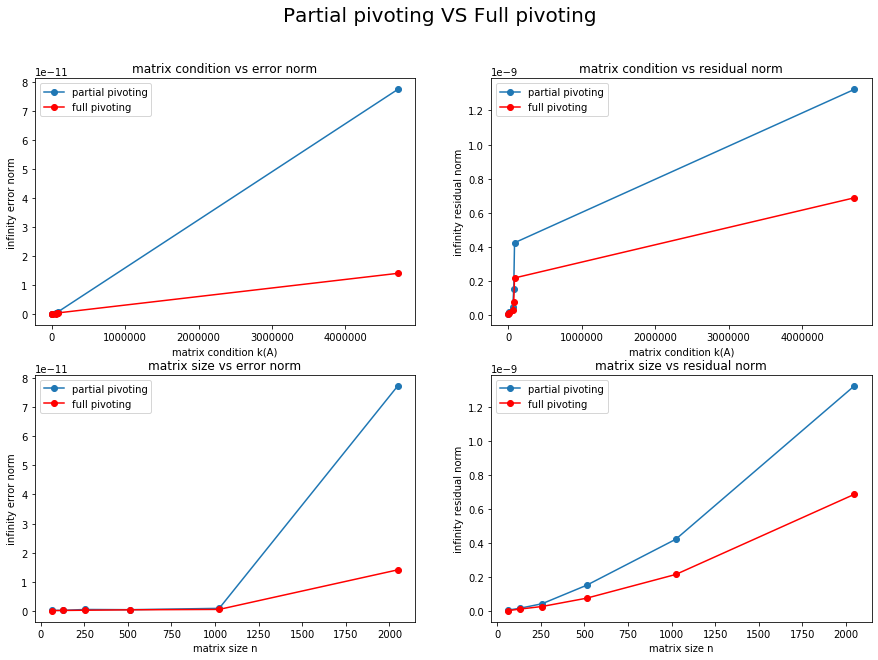

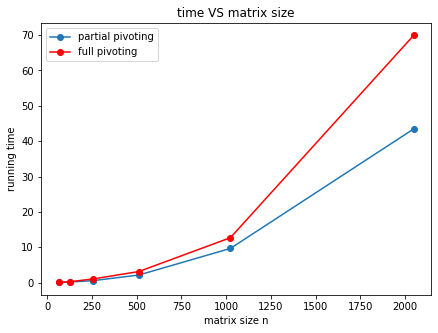

In [71]:
n = [64,128,256,512,1024,2048]
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
fig.suptitle('Partial pivoting VS Full pivoting', fontsize=20)
ax[0,0].plot(k_a,error_norm_partial,label='partial pivoting',marker='o')
ax[0,0].plot(k_a,error_norm,'r',label='full pivoting',marker='o')
ax[0,0].set_ylabel('infinity error norm')
ax[0,0].set_xlabel("matrix condition k(A)")
ax[0,0].set_title("matrix condition vs error norm")
ax[0,0].legend()

ax[0,1].plot(k_a,residual_norm_partial,label='partial pivoting',marker='o')
ax[0,1].plot(k_a,residual_norm,'r',label='full pivoting',marker='o')
ax[0,1].set_ylabel('infinity residual norm')
ax[0,1].set_xlabel("matrix condition k(A)")
ax[0,1].set_title("matrix condition vs residual norm")
ax[0,1].legend()

ax[1,0].plot(n,error_norm_partial,label='partial pivoting',marker='o')
ax[1,0].plot(n,error_norm,'r',label='full pivoting',marker='o')
ax[1,0].set_ylabel('infinity error norm')
ax[1,0].set_xlabel("matrix size n")
ax[1,0].set_title("matrix size vs error norm")
ax[1,0].legend()

ax[1,1].plot(n,residual_norm_partial,label='partial pivoting',marker='o')
ax[1,1].plot(n,residual_norm,'r',label='full pivoting',marker='o')
ax[1,1].set_ylabel('infinity residual norm')
ax[1,1].set_xlabel("matrix size n")
ax[1,1].set_title("matrix size vs residual norm")
ax[1,1].legend()

plt.figure(figsize=(7,5))
plt.plot(n,cpu_partial,marker="o",label ="partial pivoting")
plt.plot(n,cpu_full,'r',marker='o',label = "full pivoting")
plt.xlabel("matrix size n")
plt.ylabel("running time")
plt.title("time VS matrix size")
plt.legend()
plt.show()

In [66]:
error_norm = []
error_norm_partial = []
k_a = []
residual_norm = []
residual_norm_partial = []
cpu_partial = []
cpu_full = []
n = 64
for i in range(1,7):
#Construct A matrix    
    a = np.eye(n)
    a[:,n-1] = 1
    for i in range(n-1,-1,-1):
        a.T[:i,i] = -1
#calculate and append the condition of the matrix
    k_a.append(LA.cond(a, np.inf))
    x = np.ones((n,1),dtype=int)
    b = np.dot(a,x)
# call full and partial gaussian elimination for matrix A
    x_fp,time_fp = fullpivoting(np.copy(a),np.copy(b))
    x_pp,time_pp,l,u,p = partialpivoting(np.copy(a),np.copy(b))
# Compute the error 
    error_full = x_fp - x.reshape(n)
    error_partial = x_pp - x.reshape(n)
    error_norm.append(abs(error_full).max())
    error_norm_partial.append(abs(error_partial).max())
# compute the residual        
    r_full = b.reshape(n) - np.dot(a,x_fp)
    r_partial = b.reshape(n) - np.dot(a,x_pp)
    residual_norm.append(abs(r_full).max())
    residual_norm_partial.append(abs(r_partial).max())
        
    cpu_full.append(time_fp)
    cpu_partial.append(time_pp)
    n *= 2

C:\Users\potis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in subtract
C:\Users\potis\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in subtract
C:\Users\potis\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


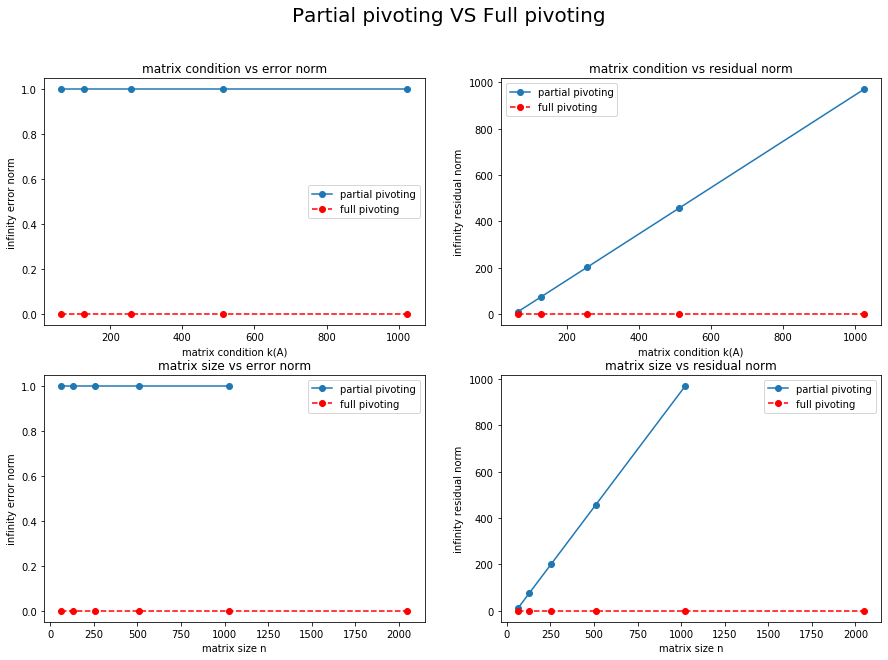

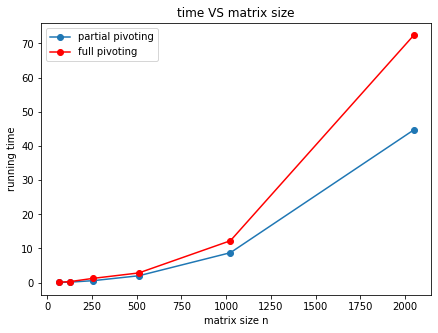

In [67]:
n = [64,128,256,512,1024,2048]
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
fig.suptitle('Partial pivoting VS Full pivoting', fontsize=20)
ax[0,0].plot(k_a,error_norm_partial,label='partial pivoting',marker='o')
ax[0,0].plot(k_a,error_norm,'--r',label='full pivoting',marker='o')
ax[0,0].set_ylabel('infinity error norm')
ax[0,0].set_xlabel("matrix condition k(A)")
ax[0,0].set_title("matrix condition vs error norm")
ax[0,0].legend()

ax[0,1].plot(k_a,residual_norm_partial,label='partial pivoting',marker='o')
ax[0,1].plot(k_a,residual_norm,'--r',label='full pivoting',marker='o')
ax[0,1].set_ylabel('infinity residual norm')
ax[0,1].set_xlabel("matrix condition k(A)")
ax[0,1].set_title("matrix condition vs residual norm")
ax[0,1].legend()

ax[1,0].plot(n,error_norm_partial,label='partial pivoting',marker='o')
ax[1,0].plot(n,error_norm,'--r',label="full pivoting",marker='o')
ax[1,0].set_ylabel('infinity error norm')
ax[1,0].set_xlabel("matrix size n")
ax[1,0].set_title("matrix size vs error norm")
ax[1,0].legend()

ax[1,1].plot(n,residual_norm_partial,label='partial pivoting',marker='o')
ax[1,1].plot(n,residual_norm,'--r',label='full pivoting',marker='o')
ax[1,1].set_ylabel('infinity residual norm')
ax[1,1].set_xlabel("matrix size n")
ax[1,1].set_title("matrix size vs residual norm")
ax[1,1].legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(n,cpu_partial,label="partial pivoting",marker='o')
plt.plot(n,cpu_full,'r',label="full pivoting",marker ="o")
plt.xlabel("matrix size n")
plt.ylabel("running time")
plt.title("time VS matrix size")
plt.legend()
plt.show()

In [180]:
n = 64
t = []
t_part = []
x_norm = []
for i in range(1,7):
    # generate a random vector
    e = 300*np.random.randn(n)
    # normalisation   
    u = e/LA.norm(e,2)
    # generate a random vector
    f = 300*np.random.randn(n)
    # normalisation
    v = f/LA.norm(f,2)
    # generate a random matrix
    a = 300*np.random.randn(n,n)
    x = np.ones((n,1),dtype=int)
    b = np.dot(a,x)
    # compute the system solution with partial pivoting
    y,o,l,u_,p = partialpivoting(np.copy(a),np.copy(b))
    # coptute the new solution according to sherman morrison theorem 
    ti,y_ = lusolv(u,v,l,u_,y)
    t.append(ti)
    # create the new matrix
    g = a + np.dot(u.reshape(-1,1),v.reshape(1,-1))
    # compute the solution of the new matrix with partial pivoting 
    x_hat,t1,l,u_,p = partialpivoting(np.copy(g),np.copy(b))
    # compute the distance between the two methods
    x_norm.append(abs(LA.norm(x_hat,2)-LA.norm(y_,2)))
    t_part.append(t1)
    n *= 2

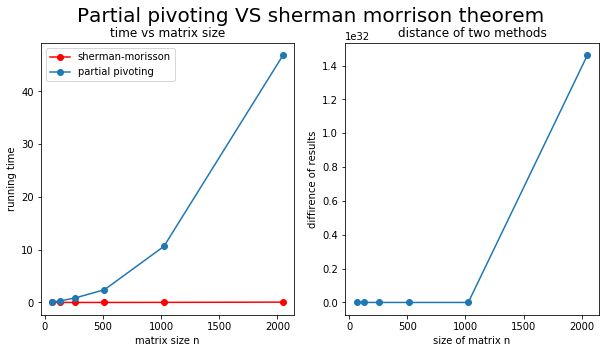

In [202]:
n = [64,128,256,512,1024,2048]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Partial pivoting VS sherman morrison theorem', fontsize=20)
ax1.plot(n,t,"r",label='sherman-morisson',marker="o")
ax1.plot(n,t_part,label='partial pivoting',marker="o")
ax1.set_xlabel('matrix size n')
ax1.set_ylabel('running time')
ax1.set_title('time vs matrix size')
ax1.legend()
ax2.plot(n,x_norm,marker="o")
ax2.set_title('distance of two methods')
ax2.set_xlabel('size of matrix n')
ax2.set_ylabel('diffirence of results')
plt.show()